In [1]:
%pylab inline
import pypropep as ppp
from CoolProp.CoolProp import PropsSI

plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('ggplot')
ppp.init()

Populating the interactive namespace from numpy and matplotlib
Loaded 1921 thermo species
Loaded 1033 propellants


## References
- Following http://www.spg-corp.com/docs/Stanford_AA284a_Lecture10.pdf to develop motor ballistic design.
- The Turnigy Aquastar T20 30T - https://hobbyking.com/en_us/turnigy-aquastar-t20-3t-730kv-1280kv-water-cooled-brushless-motor.html
- 12kW LMT Lehner 3040 motor - http://www.lehner-shop.com/en/inrunner/series-30/3040.html

In [42]:
lbf_to_N = 4.445          # N / lbf
atm_to_psia = 14.7        # psia / atm
atm_to_Pa = 101325.       # Pa / atm
psi_to_Pa = atm_to_Pa / atm_to_psia
g0 = 9.80665              # m / sec^2
Ru = 8.31432              # J / mol - K
Re = 6385e3               # m
mu_earth = 3.986004e14    # m^3 / s^2
M_air = 0.0289644         # kg/mol
gamma_air = 1.4           # Cp/Cv
P0 = 101325.              # Pa
T0 = 250.                 # K
rho0 = 1.2250             # kg / m^3

# Vehicle parameters
m_pld = 2.0       #kg
epsilon = 0.5
a0 = 4 * g0

o2 = ppp.PROPELLANTS['OXYGEN (LIQUID)']
fuel = ppp.PROPELLANTS['EICOSANE (PARAFFIN)']
rho_lox = PropsSI('D', 'P', 101325, 'Q', 0, 'Oxygen')
cstar_eff = 0.92
OF_design_point = 2.1
eta_pump = 0.4
Ns_pump = 700. / 51.64        # metric units, Likely a Barske-style pump
Ae_At = 6.

# Fuel Regression rate coefficients
a = 1.0*0.117           # paraffin+LOX, mm/sec for Gox in kg/m^2-s
n = 0.62              # paraffin+LOX
rho_fuel = 900.       # paraffin, kg/m^3
b_a_grain = 2.0

# Tank
ullage = 0.2
rho_tank = 2700.                  # Al, kg / m^3
tmin_tank = 1/8. * .0254         # m
sigma_lim_tank = 25e3 * psi_to_Pa # Pa

# Batteries
E_batt = 100 * 3600.              # J / kg

# Pressures
POT = 70.     # Psia
Pc = 680.   # Psia
T_SL = 800 * lbf_to_N      # Newtons

## Paraffin / LOX performance

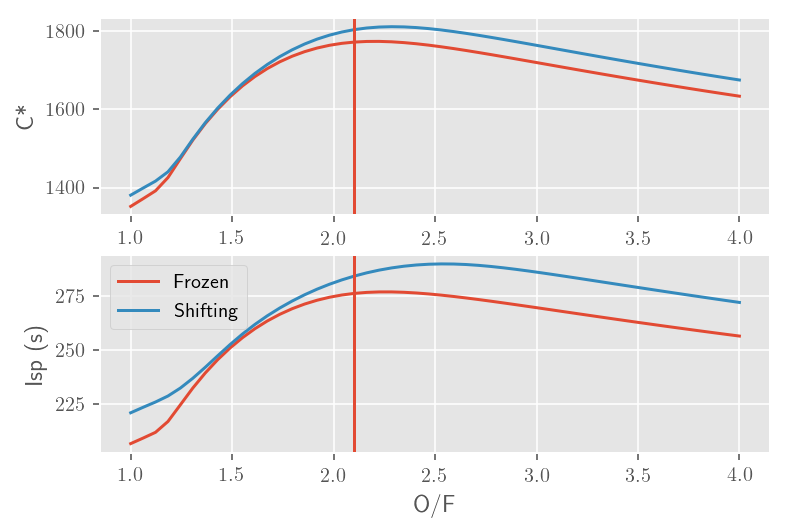

In [43]:
OF = np.linspace(1, 4)
m_fuel = 1.0
cstar_fr = []
cstar_sh = []
Isp_fr = []
Isp_sh = []
for i in xrange(len(OF)):
    p = ppp.FrozenPerformance()
    psh = ppp.ShiftingPerformance()
    
    m_O2 = OF[i]
    
    p.add_propellants_by_mass([(fuel, m_fuel), (o2, m_O2)])
    psh.add_propellants_by_mass([(fuel, m_fuel), (o2, m_O2)])
    
    p.set_state(P=Pc / atm_to_psia, Pe=1)
    psh.set_state(P=Pc / atm_to_psia, Pe=1)
    
    cstar_fr.append(p.performance.cstar)
    Isp_fr.append(p.performance.Isp/9.8)
    
    cstar_sh.append(psh.performance.cstar)
    Isp_sh.append(psh.performance.Isp/9.8)
    
ax = plt.subplot(211)
ax.plot(OF, cstar_fr, label='Frozen')
ax.plot(OF, cstar_sh, label='Shifting')
ax.axvline(OF_design_point)
ax.set_ylabel('C*')
ax1 = plt.subplot(212, sharex=ax)
ax1.plot(OF, Isp_fr, label='Frozen')
ax1.plot(OF, Isp_sh, label='Shifting')
ax1.axvline(OF_design_point)
ax1.set_ylabel('Isp (s)')
plt.xlabel('O/F')
plt.legend(loc='best')

In [44]:
# Rocket Performance
p = ppp.FrozenPerformance() #Resetting frozen performance calculation
p.add_propellants_by_mass([(fuel, 1.0), (o2, OF_design_point)])
p.set_state(P=Pc / atm_to_psia, Ae_At=Ae_At)
Pe = p.properties[2].P
Adotm = p.performance.a_dotm
cstar = cstar_eff * p.performance.cstar
C_matched = cstar_eff * p.performance.Isp
C_SL = C_matched + (Pe - 1.) * Adotm
C_vac = C_matched + Pe * Adotm

mdot = T_SL / C_SL
mdot_ox = mdot * OF_design_point / (1 + OF_design_point)
mdot_fuel = mdot / (1 + OF_design_point)

print "Sea level Isp: %.1f s" % (C_SL / g0)
print "Sea level expansion ratio: %.1f" % (Ae_At)
print "Vacuum Isp: %.1f s" % (C_vac / g0)
print "Total mass flowrate: %.3f kg/s" % mdot
print "Ox mass flowrate: %.3f kg/s, fuel: %.3f kg/s" % (mdot_ox, mdot_fuel)

# Mass sizing
m0 = T_SL / a0
ms = epsilon * m0
m_prop = m0 - ms - m_pld
mox = m_prop * OF_design_point / (1 + OF_design_point)
mfuel = m_prop - mox

t_burn = m_prop / mdot
Itot = T_SL * t_burn             # Assuming sea level, but that's ok for design

print "Vehicle gross mass: %.1f kg" % m0
print "Propellant mass: %.1f kg" % m_prop
print "Liquid Oxygen mass: %.1f kg, Fuel grain mass: %.1f kg" % (mox, mfuel)
print "Burn time: %.1f s" % (t_burn)

# Rocket motor sizing
VL = 1 - b_a_grain**-2
Dpf = (((2. * n + 1) * 2**(2. * n + 1) * (a / 1e3) / ((pi * C_SL)**n) * 
        (OF_design_point / (1. + OF_design_point))**n * Itot**n * t_burn**(1. - n) /
        (1. - (1. - VL)**((2. * n + 1)/2.)))**(1. / (2. * n + 1)))
L = 4. / pi / rho_fuel / VL * Itot / C_SL / ((1. + OF_design_point) * Dpf**2)
Dpi = Dpf / b_a_grain


Gox0 = mdot_ox / (pi * Dpi**2 / 4)

print 'Volume loading: %.2f' % (VL)
print 'Port final diameter: %.1f cm' % (Dpf*100)
print 'Grain length: %.1f cm' % (L*100)
print 'Max Gox: %.1f kg/m^2-sec' % (Gox0)

# Oxidizer Tank
OD_rocket = ceil(1.1 * Dpf / .0254) *.0254

# Check whether we hit t_min on tank
sigma_hoop = POT * psi_to_Pa * OD_rocket / 2 / tmin_tank

if sigma_hoop > sigma_lim_tank:
    t_tank = POT * psi_to_Pa * OD_rocket / 2 / sigma_lim_tank
    print "Tank NOT minimum gage"
else:
    t_tank = tmin_tank
    print "Tank wall limited by minimum gage"

ID_rocket = OD_rocket - 2 * t_tank
V_tank = (1 + ullage) * mox / rho_lox
L_tank = V_tank / (pi * ID_rocket**2 / 4)
m_tank = pi * (OD_rocket**2 - ID_rocket**2) / 4 * L_tank * rho_tank + 4. / 3 * pi * ((OD_rocket/2)**3 - (ID_rocket/2)**3) * rho_tank

print "Rocket OD: %.1f in (%.1f cm)" % (OD_rocket / .0254, OD_rocket * 100)
print "Tank length: %.1f cm" % (L_tank * 100)
print "Tank mass: %.3f kg" % (m_tank)

# Pump sizing
Q_ox = mdot_ox / rho_lox
POI = 1.1 * Pc
deltaP_pump = (POI - POT) / atm_to_psia * atm_to_Pa
P_pump = deltaP_pump * Q_ox / eta_pump
N_pump = Ns_pump / Q_ox**0.5 * (deltaP_pump / rho_lox / g0)**0.75

m_batt = P_pump * t_burn / E_batt

print "Pump power: %.3f kW" % (P_pump / 1e3)
print "Pump speed: %.1f RPM" % (N_pump)
print "Pump pressure rise: %.1f psi, head rise: %.1f m" % (deltaP_pump * atm_to_psia / atm_to_Pa , deltaP_pump / rho_lox / g0)
print "Battery mass: %.1f kg" % (m_batt)

Sea level Isp: 253.8 s
Sea level expansion ratio: 6.0
Vacuum Isp: 277.3 s
Total mass flowrate: 1.429 kg/s
Ox mass flowrate: 0.968 kg/s, fuel: 0.461 kg/s
Vehicle gross mass: 90.7 kg
Propellant mass: 43.3 kg
Liquid Oxygen mass: 29.4 kg, Fuel grain mass: 14.0 kg
Burn time: 30.3 s
Volume loading: 0.75
Port final diameter: 18.5 cm
Grain length: 76.7 cm
Max Gox: 143.3 kg/m^2-sec
Tank wall limited by minimum gage
Rocket OD: 9.0 in (22.9 cm)
Tank length: 79.6 cm
Tank mass: 6.198 kg
Pump power: 9.907 kW
Pump speed: 43001.6 RPM
Pump pressure rise: 678.0 psi, head rise: 417.6 m
Battery mass: 0.8 kg


In [45]:
#Engine Properties
from pprint import pprint
Pt = 19.006 #atm, from ppp, throat pressure
Tt = 2993.2 #K, from ppp, throat temperature
M = 20.777 #g/mol, from ppp, total molecuar weight
gamma_t = 1.229 #from ppp, throat specific heat ratio

At = (mdot / (Pt * atm_to_Pa)) * np.sqrt(Ru * Tt / (M / 1000. * gamma_t))
print "Throat Area: %.2f cm^2" % (At*10000)
dia_t = 2*np.sqrt(At/pi)
print "Throat Diameter: %.2f cm" % (dia_t*100)

Ae = At * Ae_At
print "Exit Area: %.2f cm^2" % (Ae*10000)
dia_e = 2*np.sqrt(Ae/pi)
print "Exit Diameter: %.2f cm" % (dia_e*100)

#print T_SL/(Pc*psi_to_Pa*1.52119)*10000
print('\n')
print p

Throat Area: 7.32 cm^2
Throat Diameter: 3.05 cm
Exit Area: 43.94 cm^2
Exit Diameter: 7.48 cm


Status:
	Equillibrium Computed: False
	Properties Computed: False
	Performance Computed: False
Composition:
	EICOSANE (PARAFFIN) - 0.004 mol
	OXYGEN (LIQUID) - 0.066 mol
======= Chamber =======: 
	Pressure: 46.259 atm 
	Temperature: 3360.2 K 
	Enthalpy: -908.536 kJ/kg 
	Int. Energy: -2250.087 kJ/kg 
	Gibbs Free Energy: -41552.160 kJ/kg 
	Entropy: 12.095 kJ/kg-K 
	Molar Mass: 20.826 g/mol 
	dV_P: -1.000
	dV_T: 1.000
	Cp: 2.174 kJ/kg-K
	Cv: 1.775 kJ/kg-K
	gamma: 1.225
	Sound Speed: 1249.9 m/s
	
	Ae/At: 0.00000
	A/dotm: 0.00000 m/s/atm
	C*: 0.00000 m/s
	Cf: 0.00000
	Ivac (m/s): 0.00000
	Isp (m/s): 0.00000
	Isp/g (s): 0.00000

======= Throat =======: 
	Pressure: 25.856 atm 
	Temperature: 3017.9 K 
	Enthalpy: -1648.522 kJ/kg 
	Int. Energy: -2853.389 kJ/kg 
	Gibbs Free Energy: -37450.321 kJ/kg 
	Entropy: 11.863 kJ/kg-K 
	Molar Mass: 20.826 g/mol 
	dV_P: -1.000
	dV_T: 1.000
	Cp: 2.148 kJ/kg-K
	Cv: 1

## Simple 1D Flight Sim

Text(0,0.5,'V (m/s)')

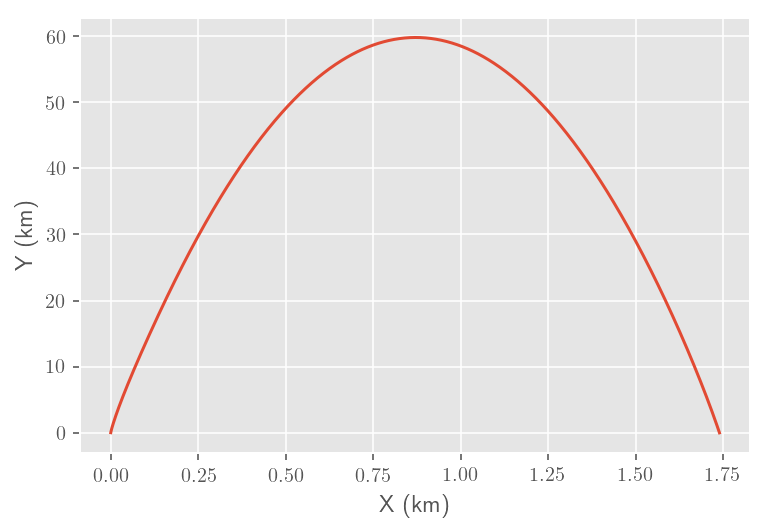

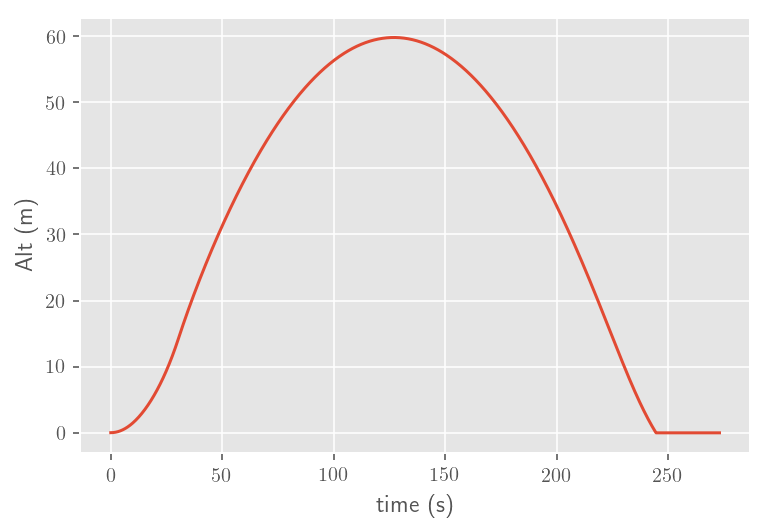

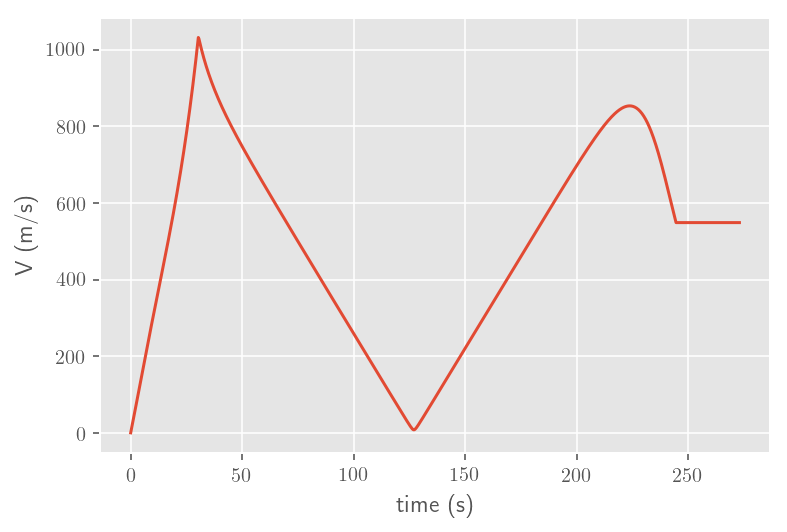

In [46]:
def std_atm(h):
    '''
    Returns T,P,rho for US Standard atmosphere given
    altitude in m.
    '''
    z = np.exp(-g0 * M_air * h / Ru / T0)
    return (P0 * z, rho0 * z)

def rk45(func, y0, tf, N, args):
    '''
    RK4 method - tv must be equally spaced.
    '''
    foo, meta = func(y0, 0,*args)
    dt = tf / N
    tv = np.linspace(0, tf, N)
    yv = np.zeros((len(tv), len(y0)))
    metav = np.zeros((len(tv), len(meta)))
    metav[0,:] = meta
    i = 0.
    y = y0
    yv[0,:] = y
    for i in xrange(0,len(tv)-1):
        t = tv[i]
        k1,meta = func(y, t, *args)
        k2,meta = func(y + k1*dt/2., t + dt/2., *args)
        k3,meta = func(y + k2*dt/2., t + dt/2., *args)
        k4,meta = func(y + k3*dt, t + dt, *args)
        y += + dt / 6. * (k1 + 2.*k2 + 2.*k3 + k4)
        yv[i+1,:] = y
        metav[i+1,:] = meta

    return tv, yv, metav

def EoM2D(y, t, mdotv, mdot_cc_frac, Cmatch, Pe, Adotm0, beta, v_po, tf):
    '''
    State vector y consists of:
    m - vehicle mass
    x - vehicle horizontal coordinate
    y - vehicle vertical coordinate
    u - vehicle local velocity vector
    gamma - vehicle flight path angle from local horizontal
    deltaV_deliv - deltaV delivered by propulsion
    deltaV_grav - gravity loss deltaV to this point
    deltaV_drag - drag deltaV to this point

    mdotv vector of initial and final propellant
    flowrate.
    mdot_cc_frac is fraction of mdot routed through main
    combustion chamber.  It is < 1 for instance in GG cycles.
    m0 is initial stage mass.  C is stage
    effective exhaust velocity and tf is burn time.
    beta is ballistic coefficient, Cd * Af / m
    '''
    m = y[0]
    u = y[3]
    gamma = y[4]
    zeta = t/tf
    alt = max(0,y[2])
    Pa, rho = std_atm(alt)
    Pa /=  101325.
    if zeta > 1:
        T = 0.
        mdot = 0.
        C = 0.
    else:
        mdot = mdotv[0] + (mdotv[1]-mdotv[0])*zeta
        Adotm = Adotm0 * mdotv[0]/mdot
        C = Cmatch + (Pe - Pa) * Adotm
        T = mdot * C * mdot_cc_frac

    a_drag = 0.5 * rho * y[3]**2 * beta
    r = alt + Re
    g = mu_earth / r / r
    if y[3] < v_po:
        dy = np.array([ -mdot,
                        u * cos(gamma),
                        u * sin(gamma),
                        T / m - g * sin(gamma) - a_drag,
                        0.0,
                        T / m,
                        g * sin(gamma),
                        a_drag])
    elif y[2] < 0:
        dy = np.array([ 0,0,0,0,0,0,0,0])
    else:
        dy = np.array([ -mdot,
                        u * cos(gamma),
                        u * sin(gamma),
                        T / m - g * sin(gamma) - a_drag,
                        - g * cos(gamma) / u,
                        T / m,
                        g * sin(gamma),
                        a_drag])
    
    if mdot > 0:
        ddV_deliv = T / mdot
    else:
        ddV_deliv = 0.
    return dy, [alt, Pa, rho, ddV_deliv, T]

gamma0 = 89.9* pi /180.
v_po = 5.
y0 = [m0, 0, 0, 0, gamma0, 0, 0, 0]
t0 = 0.

t, y, meta = rk45(EoM2D, y0, t_burn*9, 1000,
                  args=([mdot,mdot], 1.0, C_matched, Pe, 
                        Adotm, 0.4 * pi * OD_rocket**2 / 4 / m0, 
                        v_po, t_burn))

alt_bo = y[-1, 2]

plt.figure()
plt.plot(y[:, 1]/1e3, y[:, 2]/1e3)
plt.xlabel('X (km)')
plt.ylabel('Y (km)')

plt.figure()
plt.plot(t, y[:, 2]/1e3)
plt.xlabel('time (s)')
plt.ylabel('Alt (m)')

plt.figure()
plt.plot(t, y[:, 3])
plt.xlabel('time (s)')
plt.ylabel('V (m/s)')